In [7]:
#basic imports 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import spacy
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import classification_report
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
device = torch.device("mps")

In [2]:
df = pd.read_csv('/Users/aadityajoshi/Downloads/Combined Data.csv',index_col=0)

In [3]:
df['text'] = df['statement']
df['label'] = df['status']
df.drop(['statement','status'],axis=1,inplace=True)

In [90]:
import pandas as pd

def print_random_examples(df):
    # Check if the required columns exist in the DataFrame
    if 'text' not in df.columns or 'label' not in df.columns:
        print("The DataFrame must contain 'text' and 'label' columns.")
        return
    
    # Sample 5 random rows from the DataFrame
    examples = df[['text', 'label']].sample(5)
    
    # Iterate through the sampled examples and print them
    for idx, row in examples.iterrows():
        print(f"Example {idx + 1}:")
        print(f"Text: {row['text']}")
        print(f"Label: {row['label']}\n")

print_random_examples(df)

Example 2598:
Text: accord hc say bbl pre order number pretty problem â€ 1.71 million seller 1 1st album 7 comeback 7dreamie
Label: 0

Example 23792:
Text: create small subreddit post feeling accomplishment safe place judge support way call r sorrowness interested.all love fellow sad people
Label: 1

Example 7365:
Text: start promise suicide note therapist suffer mental health illness year diagnose 6 year ago hate genuinely hate med boost serotonin level store buy serotonin birthday june tell end thing year provide thing well 24 achieve significant unlike parent sibling close friend connection linkedin turn 24 recently hit hard graduate university 21 internship local bank big 4 firm consulting firm startup pay internship end summer 2020 secure time pay job unlike peer pretty successful corporate world i.e. getting promote move international office london uk t
Label: 1

Example 14210:
Text: wish people stop try help able accept want help sound cheesy situation get mad want help want hel

In [4]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
blanks = []
for i,txt,lb in df.itertuples():
    if type(txt) == str:
        if txt.isspace():
            blanks.append(i)
df.drop(blanks,inplace=True)

In [5]:
df['len'] = df['text'].apply(len)

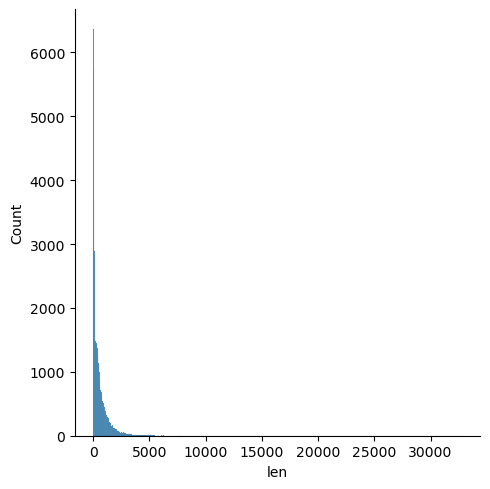

In [8]:
sns.displot(df['len'])

In [9]:
print(df['len'].quantile(0.85))

1109.0


In [12]:
ind_list = list(df[df['len'] >= 1000].index)
for i in ind_list:
    df['text'].loc[i] = df['text'].loc[i][:1000]

In [14]:
df.drop('len',axis=1,inplace=True)

In [18]:
nlp = spacy.load('en_core_web_sm')

In [19]:
#clean text
def clean_lemm(text):
    doc = nlp(text.lower())
    clean_text = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
    return ' '.join(clean_text)

In [22]:
df['text'] = df['text'].apply(clean_lemm)

In [23]:
#label
#normal - 0
#other - 1
bin_label = {'Normal':0,'Depression':1,'Suicidal':1,'Anxiety':1,'Bipolar':1,'Stress':1,'Personality disorder':1}
df['label'] = df['label'].replace(bin_label)

In [21]:
df['label'].value_counts()

label
Normal                  16040
Depression              15094
Suicidal                10644
Anxiety                  3623
Bipolar                  2501
Stress                   2296
Personality disorder      895
Name: count, dtype: int64

In [24]:
def spacy_tokenizer(text):
    clean_text = clean_lemm(text)
    return clean_text.split()

In [41]:
min_freq = 3
specials = ('<pad>','<unk>')
token_count = defaultdict(int)
for text in df['text']:
    for token in spacy_tokenizer(text):
        token_count[token] += 1
vocab = {token:idx for idx,(token,count) in enumerate(token_count.items()) if count>= min_freq}
for special in specials:
    if special not in vocab:
        vocab[special] = len(vocab)

In [42]:
vocab_size = len(vocab)
vocab_size

14810

In [43]:
#text and label pipeline
text_pipeline = lambda x : [vocab.get(token,vocab['<unk>']) for token in spacy_tokenizer(x)]
label_pipeline = lambda x : int(x)

In [48]:
#dataset
class TextDataset(Dataset):
    def __init__(self,df,text_pipeline,label_pipeline):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline
    def __len__(self):
        return len(self.texts)
    def __getitem__(self,idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return self.text_pipeline(text),self.label_pipeline(label)

In [49]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.2,random_state=32)

In [50]:
train_dataset = TextDataset(train_df,text_pipeline,label_pipeline)
test_dataset = TextDataset(test_df,text_pipeline,label_pipeline)

In [52]:
def pad_collate(batch):
    text_list = []
    label_list = []
    for text,label in batch:
        label_list.append(label)
        text_list.append(torch.LongTensor(text))
    label_list = torch.LongTensor(label_list)
    text_list = pad_sequence(text_list,batch_first=True)
    return text_list.to(device),label_list.to(device)
        

In [63]:
train_batch_size = 64
test_batch_size = 64
train_loader = DataLoader(train_dataset,train_batch_size,shuffle=True,collate_fn = pad_collate)
test_loader = DataLoader(test_dataset,test_batch_size,shuffle=False,collate_fn = pad_collate)

In [55]:
#LSTM
class LSTM(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size,num_layers,bidirectional,p=0.4):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_dir = 2 if bidirectional else 1
        self.dropout = nn.Dropout(p)
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.num_dir*hidden_size,out_size)
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embeddings = self.embedding(x)
        lstm_out,hidden = self.lstm(embeddings,hidden)
        lstm_out = self.dropout(lstm_out)
        pred = self.fc(lstm_out[:,-1,:])
        return pred
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device),
                 torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device))
        return hidden

In [64]:
lstm = LSTM(vocab_size,embedding_dim=32,hidden_size=16,out_size=2,num_layers=2,bidirectional=False).to(device)

In [65]:
lstm

LSTM(
  (dropout): Dropout(p=0.4, inplace=False)
  (embedding): Embedding(14810, 32)
  (lstm): LSTM(32, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)

In [66]:
num_epochs = 5
optimizer = torch.optim.Adam(lstm.parameters(),lr=0.005)
criterion = nn.CrossEntropyLoss()

In [67]:
import time
from tqdm import tqdm

start = time.time()
for epoch in range(num_epochs):
    lstm.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = lstm(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/5: 100%|█████████████████| 639/639 [03:49<00:00,  2.78it/s, loss=0.1140]


Epoch 1/5, Average Loss: 0.3336


Epoch 2/5: 100%|█████████████████| 639/639 [03:48<00:00,  2.80it/s, loss=0.1356]


Epoch 2/5, Average Loss: 0.1665


Epoch 3/5: 100%|█████████████████| 639/639 [03:46<00:00,  2.82it/s, loss=0.1004]


Epoch 3/5, Average Loss: 0.1332


Epoch 4/5: 100%|█████████████████| 639/639 [03:44<00:00,  2.85it/s, loss=0.1068]


Epoch 4/5, Average Loss: 0.1108


Epoch 5/5: 100%|█████████████████| 639/639 [03:45<00:00,  2.83it/s, loss=0.1592]

Epoch 5/5, Average Loss: 0.0923
Total training time: 18.90 minutes


In [68]:
all_preds = []
all_labels = []

lstm.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = lstm(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3235
           1       0.95      0.96      0.95      6984

    accuracy                           0.94     10219
   macro avg       0.93      0.93      0.93     10219
weighted avg       0.94      0.94      0.94     10219



### BILSTM

In [69]:
#BILSTM
class BILSTM(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size,num_layers,bidirectional=True,p=0.4):
        super(BILSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_dir = 2 if bidirectional else 1
        self.dropout = nn.Dropout(p)
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.num_dir*hidden_size,out_size)
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embeddings = self.embedding(x)
        lstm_out,hidden = self.lstm(embeddings,hidden)
        lstm_out = self.dropout(lstm_out)
        pred = self.fc(lstm_out[:,-1,:])
        return pred
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device),
                 torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device))
        return hidden

In [76]:
bi_lstm = BILSTM(vocab_size,embedding_dim=64,hidden_size=16,out_size=2,num_layers=2,bidirectional=True).to(device)

In [77]:
num_epochs = 5
optimizer = torch.optim.Adam(bi_lstm.parameters(),lr=0.005)
criterion = nn.CrossEntropyLoss()

start = time.time()
for epoch in range(num_epochs):
    bi_lstm.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = bi_lstm(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/5: 100%|█████████████████| 639/639 [03:51<00:00,  2.76it/s, loss=0.1199]


Epoch 1/5, Average Loss: 0.3298


Epoch 2/5: 100%|█████████████████| 639/639 [03:50<00:00,  2.77it/s, loss=0.0971]


Epoch 2/5, Average Loss: 0.1646


Epoch 3/5: 100%|█████████████████| 639/639 [03:50<00:00,  2.77it/s, loss=0.0627]


Epoch 3/5, Average Loss: 0.1272


Epoch 4/5: 100%|█████████████████| 639/639 [03:48<00:00,  2.79it/s, loss=0.0601]


Epoch 4/5, Average Loss: 0.1024


Epoch 5/5: 100%|█████████████████| 639/639 [03:49<00:00,  2.79it/s, loss=0.0898]

Epoch 5/5, Average Loss: 0.0841
Total training time: 19.18 minutes


In [78]:
all_preds = []
all_labels = []

bi_lstm.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = bi_lstm(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3235
           1       0.95      0.95      0.95      6984

    accuracy                           0.94     10219
   macro avg       0.93      0.93      0.93     10219
weighted avg       0.94      0.94      0.94     10219



### GRU

In [81]:
class GRU(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size,num_layers,bidirectional,p=0.4):
        super(GRU,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_dir = 2 if bidirectional else 1
        self.dropout = nn.Dropout(p)
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.gru = nn.GRU(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.num_dir*hidden_size,out_size)
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embeddings = self.embedding(x)
        gru_out,hidden = self.gru(embeddings,hidden)
        gru_out = self.dropout(gru_out)
        pred = self.fc(gru_out[:,-1,:])
        return pred
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device))
        return hidden

In [82]:
gru = GRU(vocab_size,embedding_dim=64,hidden_size=16,out_size=2,num_layers=2,bidirectional=False).to(device)

In [83]:
num_epochs = 5
optimizer = torch.optim.Adam(gru.parameters(),lr=0.005)
criterion = nn.CrossEntropyLoss()

start = time.time()
for epoch in range(num_epochs):
    gru.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = gru(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/5: 100%|█████████████████| 639/639 [04:47<00:00,  2.22it/s, loss=0.3129]


Epoch 1/5, Average Loss: 0.2527


Epoch 2/5: 100%|█████████████████| 639/639 [04:47<00:00,  2.22it/s, loss=0.0811]


Epoch 2/5, Average Loss: 0.1470


Epoch 3/5: 100%|█████████████████| 639/639 [04:47<00:00,  2.22it/s, loss=0.0282]


Epoch 3/5, Average Loss: 0.1123


Epoch 4/5: 100%|█████████████████| 639/639 [04:48<00:00,  2.21it/s, loss=0.3059]


Epoch 4/5, Average Loss: 0.0899


Epoch 5/5: 100%|█████████████████| 639/639 [04:46<00:00,  2.23it/s, loss=0.0069]

Epoch 5/5, Average Loss: 0.0706
Total training time: 23.97 minutes


In [84]:
all_preds = []
all_labels = []

gru.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = gru(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3235
           1       0.95      0.96      0.95      6984

    accuracy                           0.94     10219
   macro avg       0.93      0.92      0.93     10219
weighted avg       0.94      0.94      0.94     10219



In [85]:
class BIGRU(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size,num_layers,bidirectional,p=0.4):
        super(BIGRU,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_dir = 2 if bidirectional else 1
        self.dropout = nn.Dropout(p)
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.gru = nn.GRU(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.num_dir*hidden_size,out_size)
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embeddings = self.embedding(x)
        gru_out,hidden = self.gru(embeddings,hidden)
        gru_out = self.dropout(gru_out)
        pred = self.fc(gru_out[:,-1,:])
        return pred
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device))
        return hidden

In [86]:
bigru = BIGRU(vocab_size,embedding_dim=64,hidden_size=16,out_size=2,num_layers=2,bidirectional=True).to(device)

In [87]:
num_epochs = 5
optimizer = torch.optim.Adam(bigru.parameters(),lr=0.005)
criterion = nn.CrossEntropyLoss()

start = time.time()
for epoch in range(num_epochs):
    bigru.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = bigru(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/5: 100%|█████████████████| 639/639 [06:03<00:00,  1.76it/s, loss=0.1921]


Epoch 1/5, Average Loss: 0.2419


Epoch 2/5: 100%|█████████████████| 639/639 [06:06<00:00,  1.74it/s, loss=0.2623]


Epoch 2/5, Average Loss: 0.1418


Epoch 3/5: 100%|█████████████████| 639/639 [06:04<00:00,  1.75it/s, loss=0.0300]


Epoch 3/5, Average Loss: 0.1044


Epoch 4/5: 100%|█████████████████| 639/639 [06:03<00:00,  1.76it/s, loss=0.1334]


Epoch 4/5, Average Loss: 0.0790


Epoch 5/5: 100%|█████████████████| 639/639 [06:04<00:00,  1.75it/s, loss=0.1285]

Epoch 5/5, Average Loss: 0.0587
Total training time: 30.38 minutes


In [88]:
all_preds = []
all_labels = []

bigru.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = bigru(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3235
           1       0.95      0.95      0.95      6984

    accuracy                           0.93     10219
   macro avg       0.92      0.92      0.92     10219
weighted avg       0.93      0.93      0.93     10219

